# Model for crypto

In [1]:
import master_function as mf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import pandas_datareader as pdr
from master_function import data_preprocessing, plot_train_test_values
from master_function import calculate_directional_accuracy
from sklearn.metrics import mean_squared_error
import plotly.express as px

2024-04-15 21:39:33.123042: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 21:39:33.123315: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 21:39:33.125154: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 21:39:33.149049: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 21:39:33.673804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [3]:
#! pip install pandas_datareader
#! pip install plotly
#! pip install ipywidgets
# ! pip install jupyter-dash
# ! pip install tensorflow

In [4]:
crypto = mf.import_crypto("BTCUSDT", limit=1500)

In [5]:
crypto.shape

(1000, 6)

In [6]:
crypto[:1,:]

array([[1.7094456e+12, 6.1900000e+04, 6.2043000e+04, 6.1763320e+04,
        6.1865010e+04, 8.0259416e+02]])

In [7]:
close = crypto[:, 4]

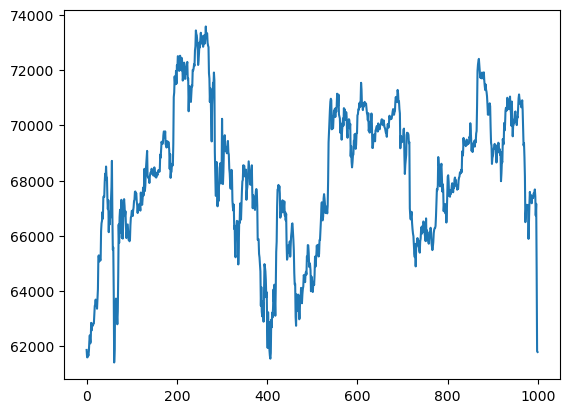

In [8]:
plt.plot(close)

In [9]:
min(close)

61410.98

In [10]:
df = pd.DataFrame(crypto[:,1:], columns=['Open', 'High', 'Low', 'Close', 'Volume'])
df.head()

,Open,High,Low,Close,Volume
0,61900.00,62043.00,61763.32,61865.01,802.59416
1,61865.01,61893.74,61320.00,61598.00,2530.94297
2,61598.01,61710.52,61393.83,61597.11,1475.61089
3,61597.10,61890.96,61556.00,61715.05,1108.63547
4,61715.05,61807.30,61606.68,61655.57,736.22474


In [11]:
timestamps = pd.to_datetime(crypto[:,0], unit="ms")

In [12]:
df.index = timestamps
timestamps.shape

(1000,)

In [13]:
max(df.index)

Timestamp('2024-04-13 21:00:00')

In [14]:
df.count()

Open      1000
High      1000
Low       1000
Close     1000
Volume    1000
dtype: int64

In [15]:
df['Close'].max()


73577.35

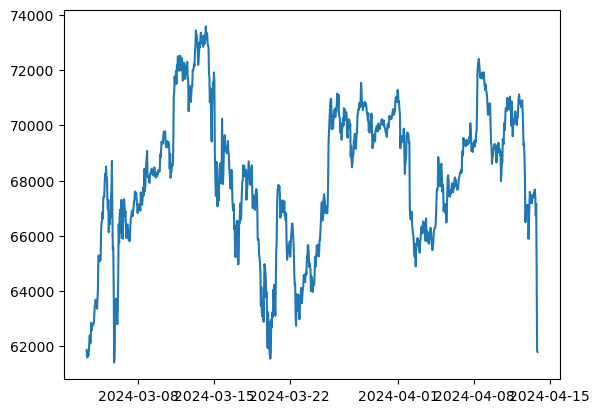

In [16]:
plt.plot( df['Close'])

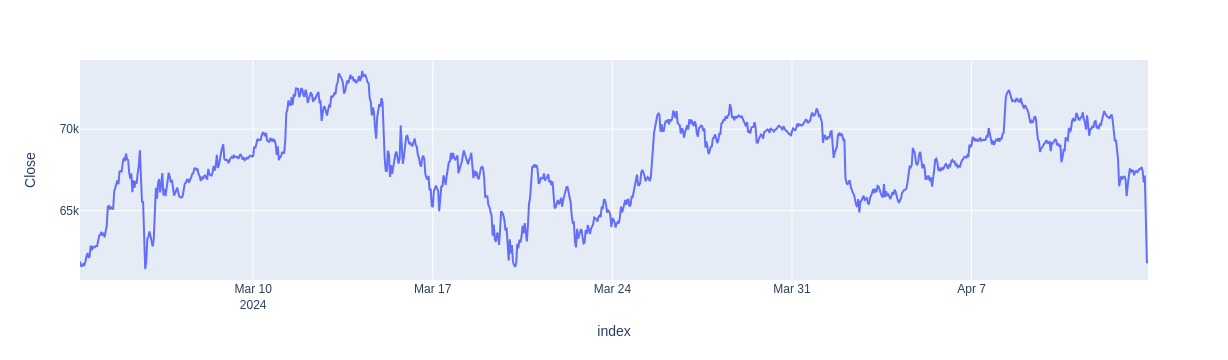

In [26]:
fig = px.line(df, x=df.index, y=df['Close'])
fig.show()

In [27]:
# Fetch S&P 500 price data
#data = np.array((pdr.get_data_fred('SP500', start = start_date, end = end_date)).dropna())

In [19]:
close_reshaped = close.reshape(-1,1)
close_reshaped.shape
data = close_reshaped

In [20]:
close.shape

(1000,)

Epoch 1/100
20/20 [==============================] - 3s 77ms/step - loss: 0.5093
Epoch 2/100
20/20 [==============================] - 2s 79ms/step - loss: 0.1568
Epoch 3/100
20/20 [==============================] - 2s 77ms/step - loss: 0.0391
Epoch 4/100
20/20 [==============================] - 2s 79ms/step - loss: 0.0237
Epoch 5/100
20/20 [==============================] - 2s 79ms/step - loss: 0.0170
Epoch 6/100
20/20 [==============================] - 2s 87ms/step - loss: 0.0200
Epoch 7/100
20/20 [==============================] - 2s 81ms/step - loss: 0.0251
Epoch 8/100
20/20 [==============================] - 2s 81ms/step - loss: 0.0159
Epoch 9/100
20/20 [==============================] - 2s 79ms/step - loss: 0.0150
Epoch 10/100
20/20 [==============================] - 2s 78ms/step - loss: 0.0152
Epoch 11/100
20/20 [==============================] - 2s 80ms/step - loss: 0.0140
Epoch 12/100
20/20 [==============================] - 2s 79ms/step - loss: 0.0147
Epoch 13/100
20/20 [=====

/home/tomasz/Projects/trading/financeML/ml/master_function.py:200: RuntimeWarning:

invalid value encountered in divide

/home/tomasz/Projects/trading/financeML/ml/master_function.py:201: RuntimeWarning:

invalid value encountered in divide

/home/tomasz/Projects/trading/financeML/ml/master_function.py:202: RuntimeWarning:

invalid value encountered in divide



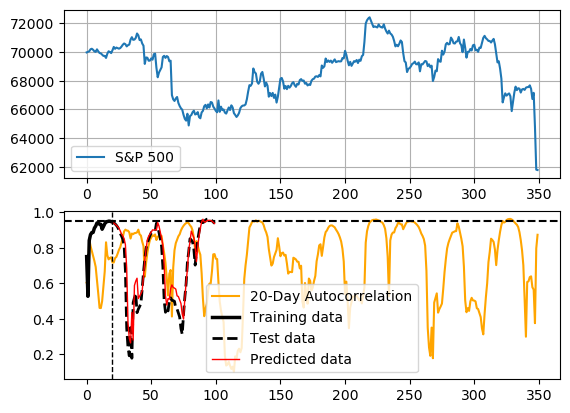

In [21]:
# Calculating a rolling autocorrelation measure
rolling_autocorr = pd.DataFrame(data).rolling(window = 20).apply(lambda x: x.autocorr(lag = 1)).dropna()
rolling_autocorr = np.reshape(np.array(rolling_autocorr), (-1))

# Plotting
fig, axes = plt.subplots(nrows = 2, ncols = 1)

axes[0].plot(data[-350:,], label = 'S&P 500', linewidth = 1.5)
axes[1].plot(rolling_autocorr[-350:,], label = '20-Day Autocorrelation', color = 'orange', linewidth = 1.5)

axes[0].legend()
axes[1].legend()

axes[0].grid()
axes[1].grid()

axes[1].axhline(y = 0.95, color = 'black', linestyle = 'dashed') 

# Setting the hyperparameters
num_lags = 500 
train_test_split = 0.80 
num_neurons_in_hidden_layers = 128 
num_epochs = 100 
batch_size = 20

# Creating the training and test sets
x_train, y_train, x_test, y_test = data_preprocessing(rolling_autocorr, num_lags, train_test_split)

# Reshape the data for LSTM input
x_train = x_train.reshape((-1, num_lags, 1))
x_test = x_test.reshape((-1, num_lags, 1))

# Create the LSTM model
model = Sequential()
model.add(LSTM(units = num_neurons_in_hidden_layers, input_shape = (num_lags, 1)))

# Adding batch normalization and dropout
model.add(BatchNormalization())
model.add(Dropout(0.1)) 

# Adding the output layer
model.add(Dense(units = 1))

# Compile the model
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

# Early stopping implementation
early_stopping = EarlyStopping(monitor = 'loss', patience = 15, restore_best_weights = True)

# Train the model
model.fit(x_train, y_train, epochs = num_epochs , batch_size = batch_size, callbacks = [early_stopping])

# Predicting in-sample
y_predicted_train = np.reshape(model.predict(x_train), (-1, 1))

# Predicting out-of-sample
y_predicted = np.reshape(model.predict(x_test), (-1, 1))

# plotting
plot_train_test_values(100, 20, y_train, y_test, y_predicted)

# Performance evaluation
print('---')
print('Accuracy Train = ', round(calculate_directional_accuracy(y_predicted_train, y_train), 2), '%')
print('Accuracy Test = ', round(calculate_directional_accuracy(y_predicted, y_test), 2), '%')
print('RMSE Train = ', round(np.sqrt(mean_squared_error(y_predicted_train, y_train)), 10))
print('RMSE Test = ', round(np.sqrt(mean_squared_error(y_predicted, y_test)), 10))
print('Correlation In-Sample Predicted/Train = ', round(np.corrcoef(np.reshape(y_predicted_train, (-1)), y_train)[0][1], 3))
print('Correlation Out-of-Sample Predicted/Test = ', round(np.corrcoef(np.reshape(y_predicted, (-1)), np.reshape(y_test, (-1)))[0][1], 3))
print('---')

In [22]:
y_train.shape

(384,)

In [23]:
y_test.shape

(97,)

/home/tomasz/Projects/trading/financeML/ml/master_function.py:200: RuntimeWarning:

invalid value encountered in divide

/home/tomasz/Projects/trading/financeML/ml/master_function.py:201: RuntimeWarning:

invalid value encountered in divide

/home/tomasz/Projects/trading/financeML/ml/master_function.py:202: RuntimeWarning:

invalid value encountered in divide



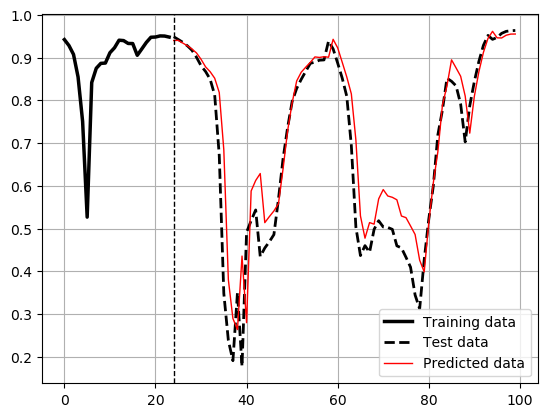

In [24]:
plot_train_test_values(100, 24, y_train, y_test, y_predicted)

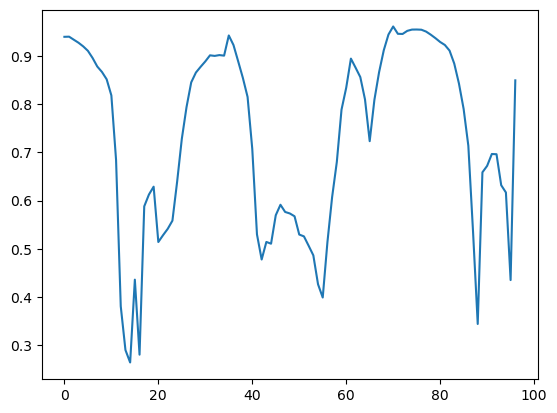

In [29]:
plt.plot(y_predicted)

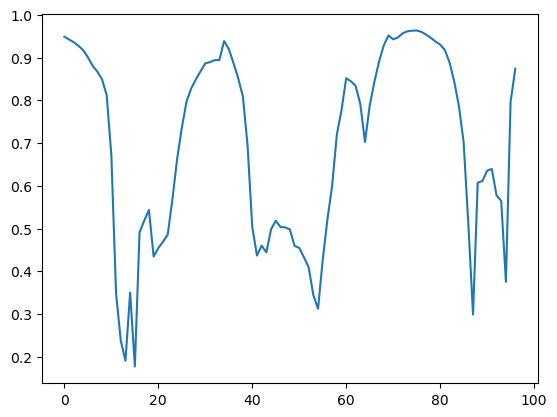

In [30]:
plt.plot(y_test)

In [44]:
y_predicted.shape

(97, 1)

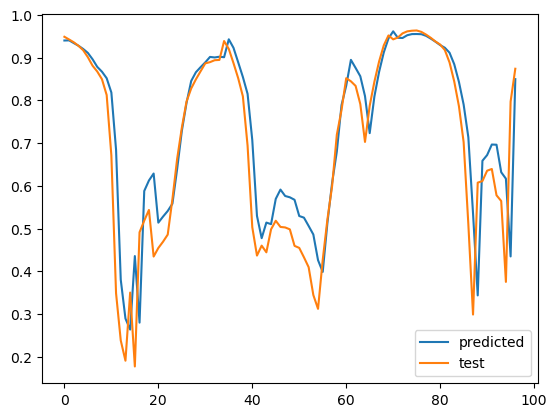

In [52]:
plt.plot(y_predicted.reshape(-1,), label="predicted")
plt.plot(y_test, label="test")
plt.legend()
plt.show()